# Importe modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *

# Plotting modules 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns

# Def functions

In [21]:
def get_season(row):
    if row['month'] >= 2 and row['month'] <= 5:
        return '1'
    elif row['month'] >= 6 and row['month'] <= 9:
        return '2'
    elif row['month'] >= 10 and row['month'] <= 12:
        return '3'
    else:
        return '3'

# Read CTL : radiative budget, tas

## CNRM-CM6-1 amip official

In [2]:
#------------- CNRM_amip : open files and read variables ----------------------
#
path_amip = "/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/"
filename_amipCTL = "*_amip_*.nc"
file_amipCTL = xr.open_mfdataset(path_amip+filename_amipCTL,combine='by_coords')
#
variables=['rlut', 'rsut','rsdt','tas']
df_amipCTL=file_amipCTL[variables].to_dataframe().drop('height',axis=1)
df1_amipCTL=df_amipCTL.reset_index(level=['time'])
df1_amipCTL['year']=pd.DatetimeIndex(df1_amipCTL['time']).year
amip_CTL=df1_amipCTL.groupby(['year']).mean()
#amip_CTL

In [3]:
# Compute radiative budget 
amip_CTL['F']=amip_CTL['rsdt']
amip_CTL['H']=amip_CTL['rsut']+amip_CTL['rlut']
amip_CTL['N']=amip_CTL['F']-amip_CTL['H']

# reshape
year_list=range(1989,2015,1)
amipCTL=amip_CTL.drop(year_list).reset_index(level=['year']).drop(axis=1,columns='year')
#amipCTL

## CNRM-CM6-1 amip r1i1p1f2

In [33]:
#------------- p1_amip : open files and read variables ----------------------
#
path_p1CTL = "/data/scratch/globc/peatier/CNRM-CM6-1_PPE/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/"
filename_p1CTL = "*_amip_*.nc"
file_p1CTL = xr.open_mfdataset(path_p1CTL+filename_p1CTL,combine='by_coords')
#
variables=['rlut', 'rsut','rsdt','tas','albisccp','pctisccp']
df_p1CTL=file_p1CTL[variables].to_dataframe().drop('height',axis=1)
df1_p1CTL=df_p1CTL.reset_index(level=['time'])
df1_p1CTL['year']=pd.DatetimeIndex(df1_p1CTL['time']).year
#p1_CTL=df1_p1CTL.groupby(['year']).mean()
df1_p1CTL

time        rlut        rsut        rsdt  \
lat        lon                                                                 
-88.927735 0.00000   1950-01-16 12:00:00  187.711685  364.914276  496.599426   
           0.00000   1950-02-15 00:00:00  166.863510  227.412476  308.395477   
           0.00000   1950-03-16 12:00:00  136.847610   44.656727   61.848026   
           0.00000   1950-04-16 00:00:00  126.371071    0.000000    0.000000   
           0.00000   1950-05-16 12:00:00  118.240364    0.000000    0.000000   
...                                  ...         ...         ...         ...   
 88.927735 358.59375 1959-08-16 12:00:00  216.526306  217.764496  314.301300   
           358.59375 1959-09-16 00:00:00  196.194336   53.368214   77.583305   
           358.59375 1959-10-16 12:00:00  192.017532    0.000000    0.000000   
           358.59375 1959-11-16 00:00:00  172.208740    0.000000    0.000000   
           358.59375 1959-12-16 12:00:00  164.839615    0.000000    0.000000   

                             tas  albisccp      pctisccp  year  
lat        lon                                                  
-88.927735 0.00000    246.845581  0.112664  54443.410156  1950  
           0.00000    236.364792  0.111117  53735.230469  1950  
           0.00000    219.709320  0.135050  46186.238281  1950  
           0.00000    214.444092       NaN           NaN  1950  
           0.00000    213.071594       NaN           NaN  1950  
...                          ...       ...           ...   ...  
 88.927735 358.59375  267.520874  0.380024  68872.289062  1959  
           358.59375  261.286896  0.391540  62361.074219  1959  
           358.59375  256.905090       NaN           NaN  1959  
           358.59375  246.863892       NaN           NaN  1959  
           358.59375  240.894653       NaN           NaN  1959  

[3932160 rows x 8 columns]

In [27]:
# Compute radiative budget 
p1_CTL['F']=p1_CTL['rsdt']
p1_CTL['H']=p1_CTL['rsut']+p1_CTL['rlut']
p1_CTL['N']=p1_CTL['F']-p1_CTL['H']

# reshape
#year_list=range(1955,1960,1)
p1CTL=p1_CTL.reset_index(level=['year']).drop(axis=1,columns='year')
p1CTL

,rlut,rsut,rsdt,tas,albisccp,pctisccp,F,H,N
0,223.041931,105.098640,299.035889,277.126770,0.369751,58849.753906,299.035889,328.140564,-29.104675
1,223.049622,105.086227,298.960663,277.219696,0.371339,58771.265625,298.960663,328.135864,-29.175201
2,222.993622,105.409241,299.029236,277.025116,0.369955,58695.269531,299.029236,328.402863,-29.373627
3,223.064346,104.889214,298.933197,277.138031,0.370612,58814.074219,298.933197,327.953552,-29.020355
4,223.491470,105.109550,298.934174,277.333130,0.371631,59021.566406,298.934174,328.601013,-29.666840
5,223.180267,105.103279,298.981812,277.167480,0.370226,58999.539062,298.981812,328.283539,-29.301727
6,223.003937,104.945175,299.156860,277.214050,0.369905,58946.003906,299.156860,327.949097,-28.792236
7,223.400589,104.941078,299.179749,277.516113,0.372163,58882.859375,299.179749,328.341675,-29.161926
8,223.295593,105.182396,299.193451,277.408600,0.371690,58808.199219,299.193451,328.477997,-29.284546
9,223.085449,105.250839,299.140472,277.334686,0.370861,58577.703125,299.140472,328.336304,-29.195831


In [42]:
#map1_p1CTL = df1_p1CTL.drop(axis = 1,columns = 'year')
map1_p1CTL['month']=pd.DatetimeIndex(df1_p1CTL['time']).month
#map_p1CTL = map1_p1CTL.groupby(['month','lat','lon']).mean()
#map_p1CTL

get_season(map_p1CTL)
map_p1CTL

KeyError: 'month'

## CNRM-CM6-1 amip r1i1p1f2

In [7]:
#------------- p1_amip : open files and read variables ----------------------
#
#path_p2CTL = "/data/scratch/globc/peatier/CNRM-CM6-1_PPE/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p2f2/"
#filename_p2CTL = "*_amip_*.nc"
#file_p2CTL = xr.open_mfdataset(path_p2CTL+filename_p2CTL,combine='by_coords')
#
#variables=['rlut', 'rsut','rsdt','tas']
#df_p2CTL=file_p2CTL[variables].to_dataframe().drop('height',axis=1)
#df1_p2CTL=df_p2CTL.reset_index(level=['time'])
#df1_p2CTL['year']=pd.DatetimeIndex(df1_p2CTL['time']).year
#p2_CTL=df1_p2CTL.groupby(['year']).mean()
#p2_CTL

In [8]:
# Compute radiative budget 
#p2_CTL['F']=p2_CTL['rsdt']
#p2_CTL['H']=p2_CTL['rsut']+p2_CTL['rlut']
#p2_CTL['N']=p2_CTL['F']-p2_CTL['H']

# reshape
#year_list=range(1955,1960,1)
#p2CTL=p2_CTL.reset_index(level=['year']).drop(axis=1,columns='year')
#p2CTL

## Create plot

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


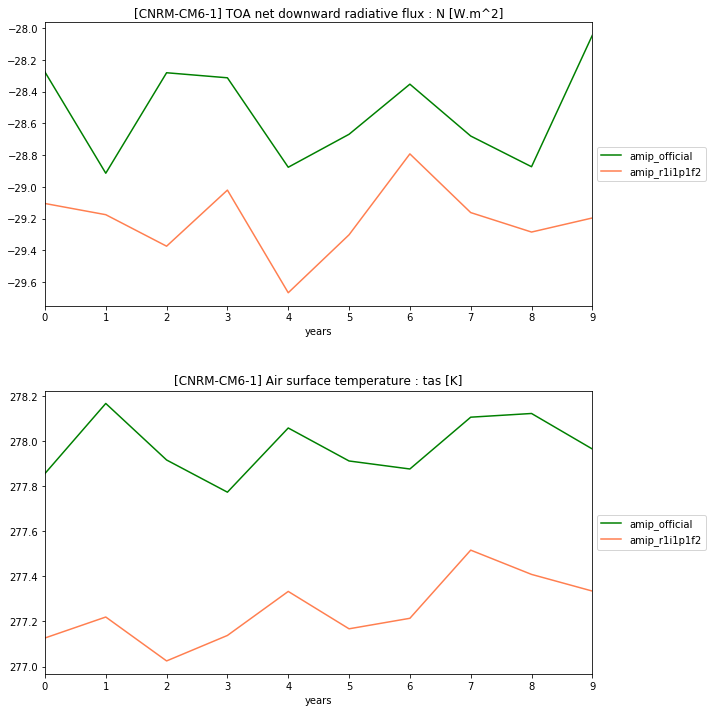

In [25]:
# Create plot of radiative budget

plt.subplots(figsize=(6,10))

plt.subplot(211)
ax=plt.gca()
amipCTL.plot(y='N',kind='line',title='[CNRM-CM6-1] TOA net downward radiative flux : N [W.m^2]',legend=True, color='green',figsize=(10,10),ax=ax)
p1CTL.plot(y='N',kind='line',legend=True, color='coral',ax=ax)
plt.xlabel('years')
ax.legend(['amip_official','amip_r1i1p1f2'],loc='center left', bbox_to_anchor=(1, 0.5))
#
# tas
plt.subplot(212)
ax1=plt.gca()
amipCTL.plot(y='tas',kind='line',title='[CNRM-CM6-1] Air surface temperature : tas [K]',legend=True, color='green',figsize=(10,10),ax=ax1)
p1CTL.plot(y='tas',kind='line',legend=True, color='coral',ax=ax1)
plt.xlabel('years')
ax1.legend(['amip_official','amip_r1i1p1f2'],loc='center left', bbox_to_anchor=(1, 0.5))

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

#   Enregistrer les figures ...............................................................

plt.savefig("/data/home/globc/peatier/figures/TOA_tas_PPE.pdf", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

# Read amip-4xCO2 : radiative budget, tas

## CNRM-CM6-1 amip-4xCO2 official

In [26]:
#------------- CNRM_amip : open files and read variables ----------------------
#
filename_amip4xCO2 = "*_amip-4xCO2_*.nc"
file_amip4xCO2 = xr.open_mfdataset(path_amip+filename_amip4xCO2,combine='by_coords')
#
variables=['rlut', 'rsut','rsdt','tas']
df_amip4xCO2=file_amip4xCO2[variables].to_dataframe().drop('height',axis=1)
df1_amip4xCO2=df_amip4xCO2.reset_index(level=['time'])
df1_amip4xCO2['year']=pd.DatetimeIndex(df1_amip4xCO2['time']).year
amip_4xCO2=df1_amip4xCO2.groupby(['year']).mean()
amip_4xCO2

,rlut,rsut,rsdt,tas
year,,,,
1979,218.133591,101.930840,299.138092,278.576202
1980,218.016190,102.276932,299.196655,278.555878
1981,218.138962,102.029541,299.127747,278.678223
1982,218.102112,102.246330,299.053345,278.502838
1983,217.914764,102.651436,299.051910,278.629791
1984,218.183029,101.771042,299.036072,278.725861
1985,217.695129,102.124008,298.933105,278.471924
1986,217.764694,102.159157,298.937439,278.602478
1987,218.235733,102.117310,298.956879,278.864166


In [28]:
# Compute radiative budget 
amip_4xCO2['F']=amip_4xCO2['rsdt']
amip_4xCO2['H']=amip_4xCO2['rsut']+amip_4xCO2['rlut']
amip_4xCO2['N']=amip_4xCO2['F']-amip_4xCO2['H']

# reshape
year_list=range(1989,2015,1)
amip4xCO2=amip_4xCO2.drop(year_list).reset_index(level=['year']).drop(axis=1,columns='year')
amip4xCO2

,rlut,rsut,rsdt,tas,F,H,N
0,218.133591,101.930840,299.138092,278.576202,299.138092,320.064423,-20.926331
1,218.016190,102.276932,299.196655,278.555878,299.196655,320.293121,-21.096466
2,218.138962,102.029541,299.127747,278.678223,299.127747,320.168518,-21.040771
3,218.102112,102.246330,299.053345,278.502838,299.053345,320.348450,-21.295105
4,217.914764,102.651436,299.051910,278.629791,299.051910,320.566193,-21.514282
5,218.183029,101.771042,299.036072,278.725861,299.036072,319.954071,-20.917999
6,217.695129,102.124008,298.933105,278.471924,298.933105,319.819153,-20.886047
7,217.764694,102.159157,298.937439,278.602478,298.937439,319.923859,-20.986420
8,218.235733,102.117310,298.956879,278.864166,298.956879,320.353027,-21.396149
9,218.024353,101.966347,299.106628,278.672028,299.106628,319.990692,-20.884064


## CNRM-CM6-1 amip-4xCO2 r1i1p1f2

In [30]:
#path_p14xCO2 = "/data/scratch/globc/peatier/CNRM-CM6-1_PPE/CNRM-CM6-1_amip-4xCO2_PPE/"
#filename_p14xCO2 = "*_amip-4xCO2_*.nc"
#file_p14xCO2 = xr.open_mfdataset(path_p14xCO2+filename_p14xCO2,combine='by_coords')
#
#variables=['rlut', 'rsut','rsdt','tas']
#df_p14xCO2=file_p14xCO2[variables].to_dataframe().drop('height',axis=1)
#df1_p14xCO2=df_p14xCO2.reset_index(level=['time'])
#df1_p14xCO2['year']=pd.DatetimeIndex(df1_p14xCO2['time']).year
#p1_4xCO2=df1_p14xCO2.groupby(['year']).mean()
#p1_4xCO2

In [21]:
# Compute radiative budget 
mri_4xCO2['F']=mri_4xCO2['rsdt']
mri_4xCO2['H']=mri_4xCO2['rsut']+mri_4xCO2['rlut']
mri_4xCO2['N']=mri_4xCO2['F']-mri_4xCO2['H']

# reshape
year_list=range(2009,2015,1)
mri4xCO2=mri_4xCO2.drop(year_list).reset_index(level=['year']).drop(axis=1,columns='year')
#mri4xCO2

### Create plot

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


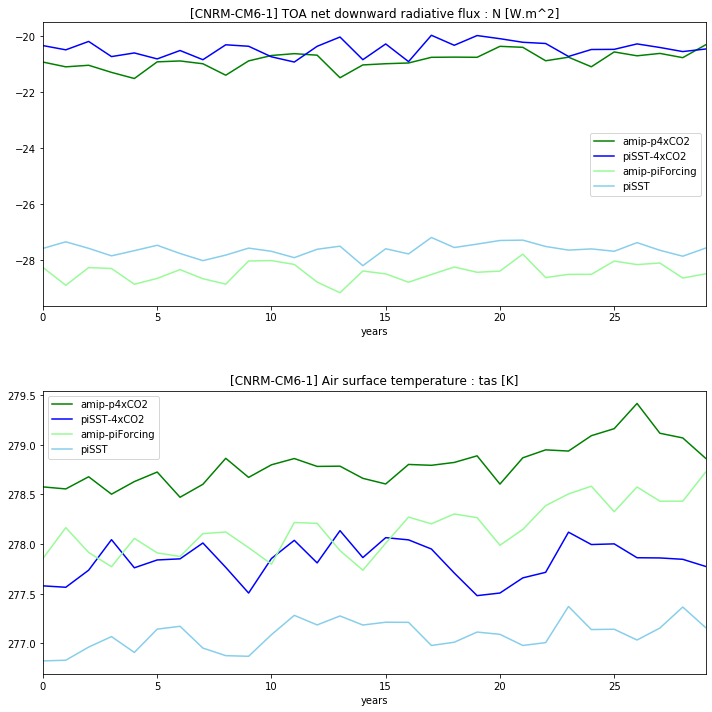

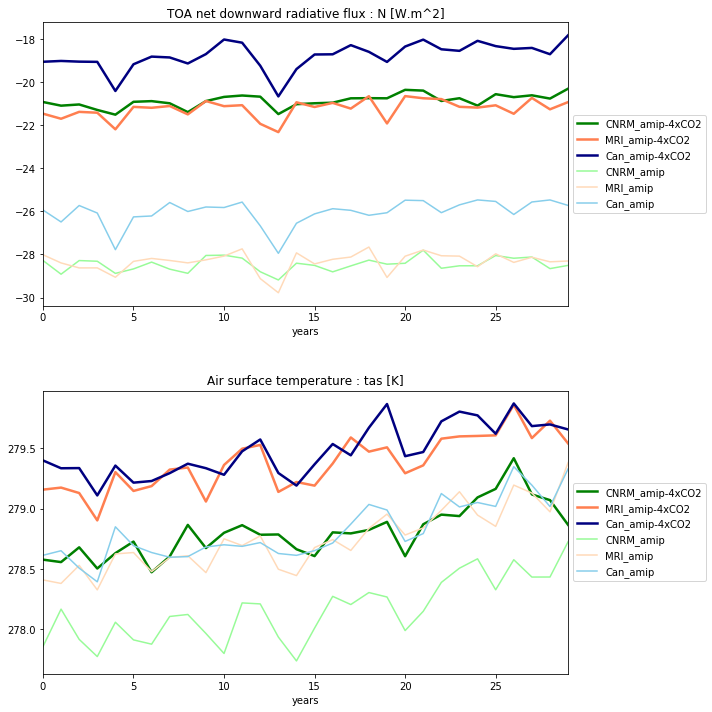

In [34]:
# Inter model comparison..............................................................
plt.subplots(figsize=(6,10))

plt.subplot(211)
ax_model=plt.gca()
amip4xCO2.plot(y='N',kind='line',title='TOA net downward radiative flux : N [W.m^2]',legend=True, color='green',figsize=(10,10),linewidth=2.5,ax=ax_model)
mri4xCO2.plot(y='N',kind='line',legend=True, color='coral',linewidth=2.5,ax=ax_model)
Can4xCO2.plot(y='N',kind='line',legend=True, color='navy',linewidth=2.5,ax=ax_model)
amipCTL.plot(y='N',kind='line',legend=True, color='palegreen',figsize=(10,10),ax=ax_model)
mriCTL.plot(y='N',kind='line',legend=True, color='peachpuff',ax=ax_model)
CanCTL.plot(y='N',kind='line',legend=True, color='skyblue',ax=ax_model)
plt.xlabel('years')
ax_model.legend(['CNRM_amip-4xCO2','MRI_amip-4xCO2','Can_amip-4xCO2','CNRM_amip','MRI_amip','Can_amip'],loc='center left', bbox_to_anchor=(1, 0.5))
#
# tas
plt.subplot(212)
ax_model1=plt.gca()
amip4xCO2.plot(y='tas',kind='line',title='Air surface temperature : tas [K]',legend=True, color='green',figsize=(10,10),linewidth=2.5,ax=ax_model1)
mri4xCO2.plot(y='tas',kind='line',legend=True, color='coral',linewidth=2.5,ax=ax_model1)
Can4xCO2.plot(y='tas',kind='line',legend=True, color='navy',linewidth=2.5,ax=ax_model1)
amipCTL.plot(y='tas',kind='line',legend=True, color='palegreen',figsize=(10,10),ax=ax_model1)
mriCTL.plot(y='tas',kind='line',legend=True, color='peachpuff',ax=ax_model1)
CanCTL.plot(y='tas',kind='line',legend=True, color='skyblue',ax=ax_model1)
plt.xlabel('years')
ax_model1.legend(['CNRM_amip-4xCO2','MRI_amip-4xCO2','Can_amip-4xCO2','CNRM_amip','MRI_amip','Can_amip'],loc='center left', bbox_to_anchor=(1, 0.5))

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

#   Enregistrer les figures ...............................................................

plt.savefig("/data/home/globc/peatier/figures/TOA_tas_multimodel.pdf", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)


# Read amip-p4K : radiative budget, tas

## CNRM-CM6-1 amip-p4K official

In [32]:
#------------- CNRM_amip-p4K : open files and read variables ----------------------
#
filename_amip4K = "*_amip-p4K_*.nc"
file_amip4K = xr.open_mfdataset(path_amip+filename_amip4K,combine='by_coords')
#
df_amip4K=file_amip4K[variables].to_dataframe().drop('height',axis=1)
df1_amip4K=df_amip4K.reset_index(level=['time'])
df1_amip4K['year']=pd.DatetimeIndex(df1_amip4K['time']).year
amip_p4K=df1_amip4K.groupby(['year']).mean()
amip_p4K

,rlut,rsut,rsdt,tas
year,,,,
1979,231.654678,102.461632,299.138092,282.769196
1980,231.456390,102.409836,299.196655,282.691742
1981,231.618195,102.378441,299.127747,282.715454
1982,231.466202,102.621429,299.053345,282.631653
1983,231.298996,102.785454,299.051910,282.812744
1984,231.528061,102.245979,299.036072,282.762970
1985,231.356277,102.511421,298.933105,282.614532
1986,231.311890,102.523132,298.937439,282.790894
1987,231.432693,102.517632,298.956879,282.814880


In [33]:
# Compute radiative budget 
amip_p4K['F']=amip_p4K['rsdt']
amip_p4K['H']=amip_p4K['rsut']+amip_p4K['rlut']
amip_p4K['N']=amip_p4K['F']-amip_p4K['H']

# reshape
year_list=range(1989,2015,1)
amip4K=amip_p4K.drop(year_list).reset_index(level=['year']).drop(axis=1,columns='year')
amip4K

,rlut,rsut,rsdt,tas,F,H,N
0,231.654678,102.461632,299.138092,282.769196,299.138092,334.116302,-34.978210
1,231.456390,102.409836,299.196655,282.691742,299.196655,333.866211,-34.669556
2,231.618195,102.378441,299.127747,282.715454,299.127747,333.996643,-34.868896
3,231.466202,102.621429,299.053345,282.631653,299.053345,334.087646,-35.034302
4,231.298996,102.785454,299.051910,282.812744,299.051910,334.084442,-35.032532
5,231.528061,102.245979,299.036072,282.762970,299.036072,333.774048,-34.737976
6,231.356277,102.511421,298.933105,282.614532,298.933105,333.867706,-34.934601
7,231.311890,102.523132,298.937439,282.790894,298.937439,333.835022,-34.897583
8,231.432693,102.517632,298.956879,282.814880,298.956879,333.950317,-34.993439
9,231.602371,102.329506,299.106628,282.737518,299.106628,333.931885,-34.825256


## CNRM-CM6-1 amip-p4K r1i1p1f2

In [34]:
#------------- CNRM_amip-p4K : open files and read variables ----------------------
#
path_p1p4K = "/data/scratch/globc/peatier/CNRM-CM6-1_PPE/CNRM-CM6-1_amip-p4K_PPE/CNRM-CM6-1_amip-p4K_r1i1p1f2/"
filename_p1p4K = "*_amip-p4K_*.nc"
file_p1p4K = xr.open_mfdataset(path_p1p4K+filename_p1p4K,combine='by_coords')
#
df_p1p4K=file_p1p4K[variables].to_dataframe().drop('height',axis=1)
df1_p1p4K=df_p1p4K.reset_index(level=['time'])
df1_p1p4K['year']=pd.DatetimeIndex(df1_p1p4K['time']).year
p1_p4K=df1_p1p4K.groupby(['year']).mean()
p1_p4K

,rlut,rsut,rsdt,tas
year,,,,
1950,223.532059,105.002861,299.035889,277.537628
1951,223.172119,105.042671,298.960663,277.293030
1952,223.399887,105.196693,299.029236,277.286835
1953,223.102493,105.115807,298.933197,277.207428
1954,223.325668,105.355843,298.934174,277.204803


In [36]:
# Compute radiative budget 
p1_p4K['F']=p1_p4K['rsdt']
p1_p4K['H']=p1_p4K['rsut']+p1_p4K['rlut']
p1_p4K['N']=p1_p4K['F']-p1_p4K['H']

# reshape
p1p4K=p1_p4K.reset_index(level=['year']).drop(axis=1,columns='year')
p1p4K

,rlut,rsut,rsdt,tas,F,H,N
0,223.532059,105.002861,299.035889,277.537628,299.035889,328.534912,-29.499023
1,223.172119,105.042671,298.960663,277.293030,298.960663,328.214783,-29.254120
2,223.399887,105.196693,299.029236,277.286835,299.029236,328.596588,-29.567352
3,223.102493,105.115807,298.933197,277.207428,298.933197,328.218292,-29.285095
4,223.325668,105.355843,298.934174,277.204803,298.934174,328.681519,-29.747345


# Read amip-future4K : radiative budget, tas

## CNRM-CM6-1 amip-future4K official

In [40]:
#------------- CNRM_amip-future4K : open files and read variables ----------------------
#
filename_amipfuture4K = "*_amip-future4K_*.nc"
file_amipfuture4K = xr.open_mfdataset(path_amip+filename_amipfuture4K,combine='by_coords')
#
df_amipfuture4K=file_amipfuture4K[variables].to_dataframe().drop('height',axis=1)
df1_amipfuture4K=df_amipfuture4K.reset_index(level=['time'])
df1_amipfuture4K['year']=pd.DatetimeIndex(df1_amipfuture4K['time']).year
amip_future4K=df1_amipfuture4K.groupby(['year']).mean()
#amip_future4K

In [41]:
# Compute radiative budget 
amip_future4K['F']=amip_future4K['rsdt']
amip_future4K['H']=amip_future4K['rsut']+amip_future4K['rlut']
amip_future4K['N']=amip_future4K['F']-amip_future4K['H']

# reshape
year_list=range(2008,2014,1)
amipfuture4K=amip_future4K.drop(year_list).reset_index(level=['year']).drop(axis=1,columns='year')
#amipfuture4K

## CNRM-CM6-1 amip-future4K r1i1p1f2

In [37]:
#------------- MRI_amip-future4K : open files and read variables ----------------------
#
path_p1future4K = "/data/scratch/globc/peatier/CNRM-CM6-1_PPE/CNRM-CM6-1_amip-future4K_PPE/CNRM-CM6-1_amip-future4K_r1i1p1f2/"
filename_p1future4K = "*_amip-future4K_*.nc"
file_p1future4K = xr.open_mfdataset(path_p1future4K+filename_p1future4K,combine='by_coords')
#
df_p1future4K=file_p1future4K[variables].to_dataframe().drop('height',axis=1)
df1_p1future4K=df_p1future4K.reset_index(level=['time'])
df1_p1future4K['year']=pd.DatetimeIndex(df1_p1future4K['time']).year
p1_future4K=df1_p1future4K.groupby(['year']).mean()
p1_future4K

,rlut,rsut,rsdt,tas
year,,,,
1950,223.469696,105.223145,299.035889,277.539337
1951,222.970993,105.135239,298.960663,277.260376
1952,223.028488,105.192177,299.029236,277.081787
1953,222.969803,105.294769,298.933197,277.213135
1954,223.236221,105.351456,298.934174,277.175720


In [38]:
# Compute radiative budget 
p1_future4K['F']=p1_future4K['rsdt']
p1_future4K['H']=p1_future4K['rsut']+p1_future4K['rlut']
p1_future4K['N']=p1_future4K['F']-p1_future4K['H']

# reshape
p1future4K=p1_future4K.reset_index(level=['year']).drop(axis=1,columns='year')
p1future4K

,rlut,rsut,rsdt,tas,F,H,N
0,223.469696,105.223145,299.035889,277.539337,299.035889,328.692841,-29.656952
1,222.970993,105.135239,298.960663,277.260376,298.960663,328.106232,-29.145569
2,223.028488,105.192177,299.029236,277.081787,299.029236,328.220673,-29.191437
3,222.969803,105.294769,298.933197,277.213135,298.933197,328.264587,-29.331390
4,223.236221,105.351456,298.934174,277.175720,298.934174,328.587677,-29.653503


## Create plot

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


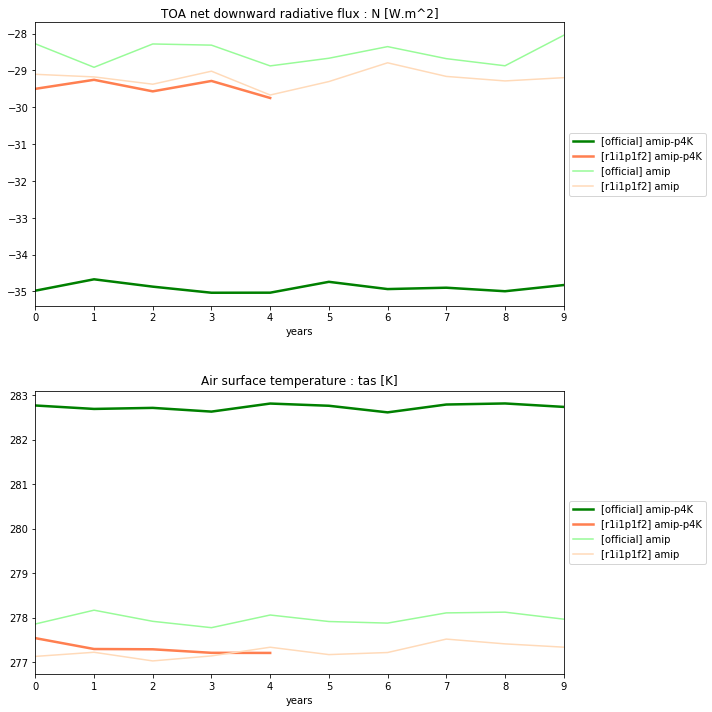

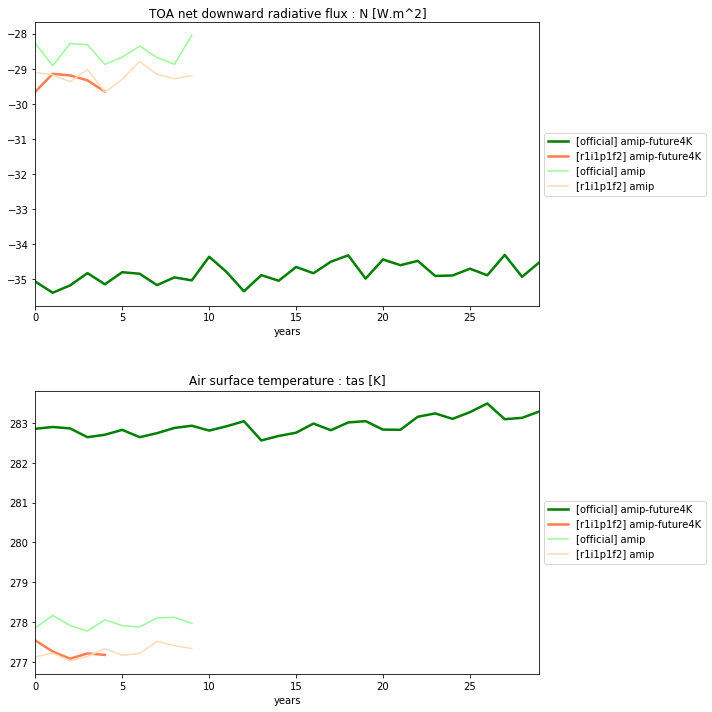

In [42]:
# Create plot of radiative budget : p4K ..........................

plt.subplots(figsize=(6,10))

plt.subplot(211)
ax=plt.gca()
amip4K.plot(y='N',kind='line',title='TOA net downward radiative flux : N [W.m^2]',legend=True, color='green',figsize=(10,10),linewidth=2.5,ax=ax)
p1p4K.plot(y='N',kind='line',legend=True, color='coral',linewidth=2.5,ax=ax)
amipCTL.plot(y='N',kind='line',legend=True, color='palegreen',figsize=(10,10),ax=ax)
p1CTL.plot(y='N',kind='line',legend=True, color='peachpuff',ax=ax)
plt.xlabel('years')
ax.legend(['[official] amip-p4K','[r1i1p1f2] amip-p4K','[official] amip', '[r1i1p1f2] amip'],loc='center left', bbox_to_anchor=(1, 0.5))
#
# tas
plt.subplot(212)
ax1=plt.gca()
amip4K.plot(y='tas',kind='line',title='Air surface temperature : tas [K]',legend=True, color='green',figsize=(10,10),linewidth=2.5,ax=ax1)
p1p4K.plot(y='tas',kind='line',legend=True, color='coral',linewidth=2.5,ax=ax1)
amipCTL.plot(y='tas',kind='line',legend=True, color='palegreen',figsize=(10,10),ax=ax1)
p1CTL.plot(y='tas',kind='line',legend=True, color='peachpuff',ax=ax1)
plt.xlabel('years')
ax1.legend(['[official] amip-p4K','[r1i1p1f2] amip-p4K','[official] amip', '[r1i1p1f2] amip'],loc='center left', bbox_to_anchor=(1, 0.5))


#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

# Enregistrer es figures .........................................

plt.savefig("/data/home/globc/peatier/figures/TOA_tas_amip-p4K_PPE.pdf", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

# Create plot of radiative budget : future4K ..........................

plt.subplots(figsize=(6,10))

plt.subplot(211)
ax2=plt.gca()
amipfuture4K.plot(y='N',kind='line',legend=True,title='TOA net downward radiative flux : N [W.m^2]', color='green',figsize=(10,10),linewidth=2.5,ax=ax2)
p1future4K.plot(y='N',kind='line',legend=True, color='coral',linewidth=2.5,ax=ax2)
amipCTL.plot(y='N',kind='line',legend=True, color='palegreen',figsize=(10,10),ax=ax2)
p1CTL.plot(y='N',kind='line',legend=True, color='peachpuff',ax=ax2)
plt.xlabel('years')
ax2.legend(['[official] amip-future4K','[r1i1p1f2] amip-future4K','[official] amip', '[r1i1p1f2] amip'],loc='center left', bbox_to_anchor=(1, 0.5))
#
# tas
plt.subplot(212)
ax3=plt.gca()
amipfuture4K.plot(y='tas',kind='line',title='Air surface temperature : tas [K]',legend=True, color='green',figsize=(10,10),linewidth=2.5,ax=ax3)
p1future4K.plot(y='tas',kind='line',legend=True, color='coral',linewidth=2.5,ax=ax3)
amipCTL.plot(y='tas',kind='line',legend=True, color='palegreen',figsize=(10,10),ax=ax3)
p1CTL.plot(y='tas',kind='line',legend=True, color='peachpuff',ax=ax3)
plt.xlabel('years')
ax3.legend(['[official] amip-future4K','[r1i1p1f2] amip-future4K','[official] amip', '[r1i1p1f2] amip'],loc='center left', bbox_to_anchor=(1, 0.5))

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

# Enregistrer des figures .........................................

plt.savefig("/data/home/globc/peatier/figures/TOA_tas_amip-future4K_PPE.pdf", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

# Compute : Delta(TOA), Delta(tas), Lambda

In [56]:
result= pd.DataFrame()

i=1
N=len(amip4xCO2)

Lbda_amip=[]
Lbda_sst=[]
Lbda_amip4K=[]
Lbda_amipfuture4K=[]

Lbda_mri=[]
Lbda_mrip4K=[]
Lbda_mrifuture4K=[]

Lbda_Can=[]
Lbda_Canp4K=[]
Lbda_Canfuture4K=[]

DN_amip=[]
DN_sst=[]
DN_amip4K=[]
DN_amipfuture4K=[]

DN_mri=[]
DN_mrip4K=[]
DN_mrifuture4K=[]

DN_Can=[]
DN_Canp4K=[]
DN_Canfuture4K=[]

Dtas_amip=[]
Dtas_sst=[]
Dtas_amip4K=[]
Dtas_amipfuture4K=[]

Dtas_mri=[]
Dtas_mrip4K=[]
Dtas_mrifuture4K=[]

Dtas_Can=[]
Dtas_Canp4K=[]
Dtas_Canfuture4K=[]

while i<N:
    
    amipCTL_tmp=amipCTL.iloc[0:i,:]
    sstCTL_tmp=sstCTL.iloc[0:i,:]    
    mriCTL_tmp=mriCTL.iloc[0:i,:]
    CanCTL_tmp=CanCTL.iloc[0:i,:]
    
    amip4xCO2_tmp=amip4xCO2.iloc[0:i,:]
    Delta_N_amip=(amip4xCO2_tmp['N']-amipCTL_tmp['N']).mean()
    Delta_tas_amip=(amip4xCO2_tmp['tas']-amipCTL_tmp['tas']).mean()
    Lambda_amip=Delta_N_amip/Delta_tas_amip
    Lbda_amip.append(Lambda_amip)
    DN_amip.append(Delta_N_amip)
    Dtas_amip.append(Delta_tas_amip)
    
    sst4xCO2_tmp=sst4xCO2.iloc[0:i,:]
    Delta_N_sst=sst4xCO2_tmp['N'].mean()-sstCTL_tmp['N'].mean()
    Delta_tas_sst=sst4xCO2_tmp['tas'].mean()-sstCTL_tmp['tas'].mean()
    Lambda_sst=Delta_N_sst/Delta_tas_sst
    Lbda_sst.append(Lambda_sst)
    DN_sst.append(Delta_N_sst)
    Dtas_sst.append(Delta_tas_sst)
        
    amip4K_tmp=amip4K.iloc[0:i,:]
    Delta_N_amip4K=amip4K_tmp['N'].mean()-amipCTL_tmp['N'].mean()
    Delta_tas_amip4K=amip4K_tmp['tas'].mean()-amipCTL_tmp['tas'].mean()
    Lambda_amip4K=Delta_N_amip4K/Delta_tas_amip4K
    Lbda_amip4K.append(Lambda_amip4K)
    DN_amip4K.append(Delta_N_amip4K)
    Dtas_amip4K.append(Delta_tas_amip4K)    
    
    amipfuture4K_tmp=amipfuture4K.iloc[0:i,:]
    Delta_N_amipfuture4K=amipfuture4K_tmp['N'].mean()-amipCTL_tmp['N'].mean()
    Delta_tas_amipfuture4K=amipfuture4K_tmp['tas'].mean()-amipCTL_tmp['tas'].mean()
    Lambda_amipfuture4K=Delta_N_amipfuture4K/Delta_tas_amipfuture4K
    Lbda_amipfuture4K.append(Lambda_amipfuture4K)
    DN_amipfuture4K.append(Delta_N_amipfuture4K)
    Dtas_amipfuture4K.append(Delta_tas_amipfuture4K)   

    mri4xCO2_tmp=mri4xCO2.iloc[0:i,:]
    Delta_N_mri=(mri4xCO2_tmp['N']-mriCTL_tmp['N']).mean()
    Delta_tas_mri=(mri4xCO2_tmp['tas']-mriCTL_tmp['tas']).mean()
    Lambda_mri=Delta_N_mri/Delta_tas_mri
    Lbda_mri.append(Lambda_mri)
    DN_mri.append(Delta_N_mri)
    Dtas_mri.append(Delta_tas_mri)    

    mrip4K_tmp=mrip4K.iloc[0:i,:]
    Delta_N_mrip4K=mrip4K_tmp['N'].mean()-mriCTL_tmp['N'].mean()
    Delta_tas_mrip4K=mrip4K_tmp['tas'].mean()-mriCTL_tmp['tas'].mean()
    Lambda_mrip4K=Delta_N_mrip4K/Delta_tas_mrip4K
    Lbda_mrip4K.append(Lambda_mrip4K)
    DN_mrip4K.append(Delta_N_mrip4K)
    Dtas_mrip4K.append(Delta_tas_mrip4K)    
    
    mrifuture4K_tmp=mrifuture4K.iloc[0:i,:]
    Delta_N_mrifuture4K=mrifuture4K_tmp['N'].mean()-mriCTL_tmp['N'].mean()
    Delta_tas_mrifuture4K=mrifuture4K_tmp['tas'].mean()-mriCTL_tmp['tas'].mean()
    Lambda_mrifuture4K=Delta_N_mrifuture4K/Delta_tas_mrifuture4K
    Lbda_mrifuture4K.append(Lambda_mrifuture4K)
    DN_mrifuture4K.append(Delta_N_mrifuture4K)
    Dtas_mrifuture4K.append(Delta_tas_mrifuture4K)     
    
    Can4xCO2_tmp=Can4xCO2.iloc[0:i,:]
    Delta_N_Can=(Can4xCO2_tmp['N']-CanCTL_tmp['N']).mean()
    Delta_tas_Can=(Can4xCO2_tmp['tas']-CanCTL_tmp['tas']).mean()
    Lambda_Can=Delta_N_Can/Delta_tas_Can
    Lbda_Can.append(Lambda_Can)
    DN_Can.append(Delta_N_Can)
    Dtas_Can.append(Delta_tas_Can)    

    Canp4K_tmp=Canp4K.iloc[0:i,:]
    Delta_N_Canp4K=Canp4K_tmp['N'].mean()-CanCTL_tmp['N'].mean()
    Delta_tas_Canp4K=Canp4K_tmp['tas'].mean()-CanCTL_tmp['tas'].mean()
    Lambda_Canp4K=Delta_N_Canp4K/Delta_tas_Canp4K
    Lbda_Canp4K.append(Lambda_Canp4K)
    DN_Canp4K.append(Delta_N_Canp4K)
    Dtas_Canp4K.append(Delta_tas_Canp4K)    
    
    Canfuture4K_tmp=Canfuture4K.iloc[0:i,:]
    Delta_N_Canfuture4K=Canfuture4K_tmp['N'].mean()-CanCTL_tmp['N'].mean()
    Delta_tas_Canfuture4K=Canfuture4K_tmp['tas'].mean()-CanCTL_tmp['tas'].mean()
    Lambda_Canfuture4K=Delta_N_Canfuture4K/Delta_tas_Canfuture4K
    Lbda_Canfuture4K.append(Lambda_Canfuture4K)
    DN_Canfuture4K.append(Delta_N_Canfuture4K)
    Dtas_Canfuture4K.append(Delta_tas_Canfuture4K)       
    
    
    i=i+1
 
result['Delta_N_amip4xCO2']=DN_amip
result['Delta_tas_amip4xCO2']=Dtas_amip
result['Lambda_amip4xCO2']=Lbda_amip

result['Delta_N_amip4K']=DN_amip4K
result['Delta_tas_amip4K']=Dtas_amip4K
result['Lambda_amip4K']=Lbda_amip4K

result['Delta_N_amipfuture4K']=DN_amipfuture4K
result['Delta_tas_amipfuture4K']=Dtas_amipfuture4K
result['Lambda_amipfuture4K']=Lbda_amipfuture4K

result['Delta_N_mri4xCO2']=DN_mri
result['Delta_tas_mri4xCO2']=Dtas_mri
result['Lambda_mri4xCO2']=Lbda_mri

result['Delta_N_mrip4K']=DN_mrip4K
result['Delta_tas_mrip4K']=Dtas_mrip4K
result['Lambda_mrip4K']=Lbda_mrip4K

result['Delta_N_mrifuture4K']=DN_mrifuture4K
result['Delta_tas_mrifuture4K']=Dtas_mrifuture4K
result['Lambda_mrifuture4K']=Lbda_mrifuture4K

result['Delta_N_Can4xCO2']=DN_Can
result['Delta_tas_Can4xCO2']=Dtas_Can
result['Lambda_Can4xCO2']=Lbda_Can

result['Delta_N_Canp4K']=DN_Canp4K
result['Delta_tas_Canp4K']=Dtas_Canp4K
result['Lambda_Canp4K']=Lbda_Canp4K

result['Delta_N_Canfuture4K']=DN_Canfuture4K
result['Delta_tas_Canfuture4K']=Dtas_Canfuture4K
result['Lambda_Canfuture4K']=Lbda_Canfuture4K

result['Delta_N_sst']=DN_sst
result['Delta_tas_sst']=Dtas_sst
result['Lambda_sst']=Lbda_sst

result

,Delta_N_amip4xCO2,Delta_tas_amip4xCO2,Lambda_amip4xCO2,Delta_N_amip4K,Delta_tas_amip4K,Lambda_amip4K,Delta_N_amipfuture4K,Delta_tas_amipfuture4K,Lambda_amipfuture4K,Delta_N_mri4xCO2,...,Lambda_Can4xCO2,Delta_N_Canp4K,Delta_tas_Canp4K,Lambda_Canp4K,Delta_N_Canfuture4K,Delta_tas_Canfuture4K,Lambda_Canfuture4K,Delta_N_sst,Delta_tas_sst,Lambda_sst
0,7.350189,0.720551,10.200796,-6.701691,4.913544,-1.363922,-6.799255,4.998291,-1.360316,6.544800,...,8.743597,-5.244415,4.655975,-1.126384,-5.434570,4.965637,-1.094436,7.258270,0.756134,9.599185
1,7.583893,0.555115,13.661847,-6.228592,4.719543,-1.319745,-6.639771,4.865326,-1.364712,6.616394,...,9.758965,-4.869385,4.690308,-1.038180,-5.147125,4.885956,-1.053453,7.064407,0.745544,9.475501
2,7.469401,0.624268,11.965063,-6.348295,4.746307,-1.337523,-6.727457,4.892548,-1.375042,6.823618,...,9.143152,-5.118784,4.735535,-1.080930,-5.429779,4.895142,-1.109218,7.177723,0.755249,9.503783
3,7.356522,0.650658,11.306286,-6.441551,4.774414,-1.349182,-6.676025,4.886810,-1.366131,6.917053,...,9.297636,-5.259918,4.792480,-1.097536,-5.572746,4.919037,-1.132894,7.166069,0.810486,8.841696
4,7.357642,0.634985,11.587105,-6.384466,4.770599,-1.338294,-6.596071,4.838684,-1.363195,6.905982,...,10.048526,-5.119581,4.738403,-1.080444,-5.432404,4.872711,-1.114863,7.147955,0.818878,8.728960
5,7.423147,0.664922,11.163935,-6.331942,4.784088,-1.323542,-6.519968,4.851471,-1.343916,6.949316,...,10.501226,-5.122925,4.717773,-1.085878,-5.373325,4.872925,-1.102690,7.068192,0.798523,8.851583
6,7.429421,0.655099,11.340914,-6.367590,4.777618,-1.332796,-6.517015,4.839417,-1.346653,6.954769,...,10.753525,-5.101864,4.707397,-1.083797,-5.302910,4.857391,-1.091720,7.096235,0.781494,9.080343
7,7.462406,0.635353,11.745290,-6.348873,4.766113,-1.332086,-6.514500,4.814240,-1.353173,6.981014,...,10.609980,-5.131077,4.711487,-1.089057,-5.358395,4.859375,-1.102692,7.108017,0.816162,8.709075
8,7.464023,0.647247,11.531949,-6.323479,4.757996,-1.329022,-6.466572,4.807404,-1.345128,6.970767,...,10.396472,-5.180616,4.728821,-1.095541,-5.383980,4.872772,-1.104911,7.154505,0.824280,8.679705
9,7.433728,0.653293,11.378860,-6.369144,4.759521,-1.338190,-6.519493,4.823242,-1.351683,7.010404,...,10.441689,-5.221626,4.738739,-1.101902,-5.396332,4.885437,-1.104575,7.161434,0.805573,8.889869


In [57]:
# Lambda mean : 

L_amip=Lbda_amip[10:28]
Lamip=mean(L_amip)
#Lamip

L_sst=Lbda_sst[10:28]
Lsst=mean(L_sst)
#Lsst

L_amip4K=Lbda_amip4K[10:28]
Lamip4K=mean(L_amip4K)
#Lamip4K

L_amipfuture4K=Lbda_amipfuture4K[10:28]
Lamipfuture4K=mean(L_amipfuture4K)
Lamipfuture4K


-1.3367628

# Create plots

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


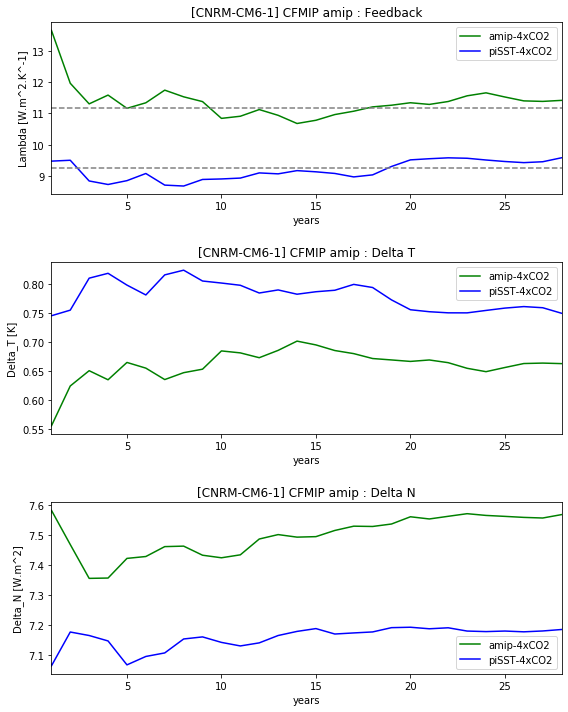

In [65]:
#--------------------------- Plot result : 4xCO2, amip and SST --------------------------------------
plt.subplots(figsize=(8,10))

plt.subplot(311)
ax2=plt.gca()
result.plot(y='Lambda_amip4xCO2',kind='line',title='[CNRM-CM6-1] CFMIP amip : Feedback',legend=True, color='green',ax=ax2)
result.plot(y='Lambda_sst',kind='line',legend=True, color='blue',ax=ax2)
ax2.axhline(y=Lamip, xmin=0, xmax=36, ls='--', color='grey')
ax2.axhline(y=Lsst, xmin=0, xmax=36, ls='--', color='grey')
ax2.set_xlabel('years')
ax2.set_ylabel('Lambda [W.m^2.K^-1]')
ax2.legend(['amip-4xCO2','piSST-4xCO2'])
#ax2.set_ylim([6,10])
ax2.set_xlim([1,28])

plt.subplot(312)
ax3=plt.gca()
result.plot(y='Delta_tas_amip4xCO2',kind='line',title='[CNRM-CM6-1] CFMIP amip : Delta T',legend=True, color='green',ax=ax3)
result.plot(y='Delta_tas_sst',kind='line',legend=True, color='blue',ax=ax3)
ax3.set_xlabel('years')
ax3.set_ylabel('Delta_T [K]')
ax3.legend(['amip-4xCO2','piSST-4xCO2'])
#ax3.set_ylim([0,2])
ax3.set_xlim([1,28])

plt.subplot(313)
ax4=plt.gca()
result.plot(y='Delta_N_amip4xCO2',kind='line',color='green',title='[CNRM-CM6-1] CFMIP amip : Delta N',legend=True,ax=ax4)
result.plot(y='Delta_N_sst',kind='line',color='blue',legend=True,ax=ax4)
ax4.set_xlabel('years')
ax4.set_ylabel('Delta_N [W.m^2]')
ax4.legend(['amip-4xCO2','piSST-4xCO2'])
#ax4.set_ylim([6.5,8.5])
ax4.set_xlim([1,28])

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.40)

# Enregistrement de la figure ......................................

plt.savefig("/data/home/globc/peatier/figures/Lambda_amip-piSST_CNRM.pdf", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


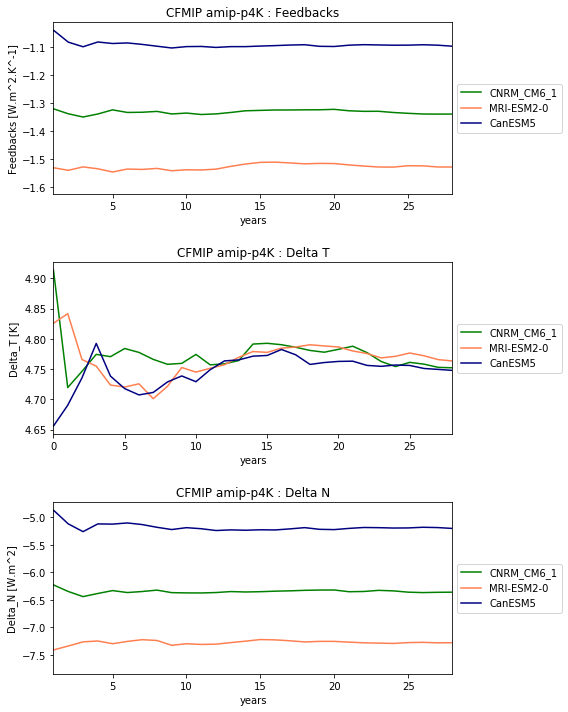

In [69]:
#--------------------------- Plot result : p4K --------------------------------------
plt.subplots(figsize=(8,10))

plt.subplot(311)
ax_4K=plt.gca()
result.plot(y='Lambda_amip4K',kind='line',title='CFMIP amip-p4K : Feedbacks',legend=True, color='green',ax=ax_4K)
result.plot(y='Lambda_mrip4K',kind='line',legend=True, color='coral',ax=ax_4K)
result.plot(y='Lambda_Canp4K',kind='line',legend=True, color='navy',ax=ax_4K)
ax_4K.set_xlabel('years')
ax_4K.set_ylabel('Feedbacks [W.m^2.K^-1]')
ax_4K.legend(['CNRM_CM6_1','MRI-ESM2-0','CanESM5'],loc='center left', bbox_to_anchor=(1, 0.5))
#ax2.set_ylim([6,10])
ax_4K.set_xlim([1,28])

plt.subplot(312)
ax_4K1=plt.gca()
result.plot(y='Delta_tas_amip4K',kind='line',title='CFMIP amip-p4K : Delta T',legend=True, color='green',ax=ax_4K1)
result.plot(y='Delta_tas_mrip4K',kind='line',legend=True, color='coral',ax=ax_4K1)
result.plot(y='Delta_tas_Canp4K',kind='line',legend=True, color='navy',ax=ax_4K1)
ax_4K1.set_xlabel('years')
ax_4K1.set_ylabel('Delta_T [K]')
ax_4K1.legend(['CNRM_CM6_1','MRI-ESM2-0','CanESM5'],loc='center left', bbox_to_anchor=(1, 0.5))
#ax_4K1.set_ylim([0,3])
ax3.set_xlim([1,28])

plt.subplot(313)
ax_4K2=plt.gca()
result.plot(y='Delta_N_amip4K',kind='line',color='green',title='CFMIP amip-p4K : Delta N',legend=True,ax=ax_4K2)
result.plot(y='Delta_N_mrip4K',kind='line',legend=True, color='coral',ax=ax_4K2)
result.plot(y='Delta_N_Canp4K',kind='line',legend=True, color='navy',ax=ax_4K2)
ax_4K2.set_xlabel('years')
ax_4K2.set_ylabel('Delta_N [W.m^2]')
ax_4K2.legend(['CNRM_CM6_1','MRI-ESM2-0','CanESM5'],loc='center left', bbox_to_anchor=(1, 0.5))
#ax_4K2.set_ylim([6.5,9.5])
ax_4K2.set_xlim([1,28])

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.40)

# Enregistrement de la figure ......................................

plt.savefig("/data/home/globc/peatier/figures/Lambda_amip-p4K_multimodel.pdf", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


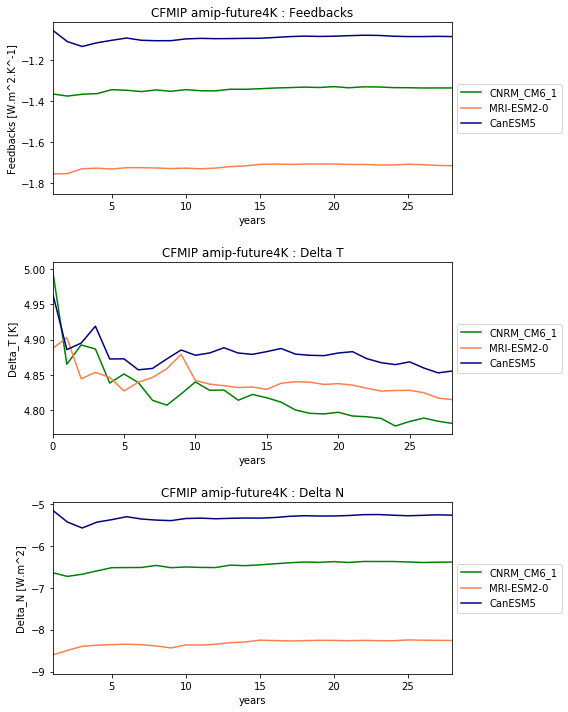

In [70]:
#--------------------------- Plot result : future4K --------------------------------------
plt.subplots(figsize=(8,10))

plt.subplot(311)
ax_4K=plt.gca()
result.plot(y='Lambda_amipfuture4K',kind='line',title='CFMIP amip-future4K : Feedbacks',legend=True, color='green',ax=ax_4K)
result.plot(y='Lambda_mrifuture4K',kind='line',legend=True, color='coral',ax=ax_4K)
result.plot(y='Lambda_Canfuture4K',kind='line',legend=True, color='navy',ax=ax_4K)
ax_4K.set_xlabel('years')
ax_4K.set_ylabel('Feedbacks [W.m^2.K^-1]')
ax_4K.legend(['CNRM_CM6_1','MRI-ESM2-0','CanESM5'],loc='center left', bbox_to_anchor=(1, 0.5))
#ax2.set_ylim([6,10])
ax_4K.set_xlim([1,28])

plt.subplot(312)
ax_4K1=plt.gca()
result.plot(y='Delta_tas_amipfuture4K',kind='line',title='CFMIP amip-future4K : Delta T',legend=True, color='green',ax=ax_4K1)
result.plot(y='Delta_tas_mrifuture4K',kind='line',legend=True, color='coral',ax=ax_4K1)
result.plot(y='Delta_tas_Canfuture4K',kind='line',legend=True, color='navy',ax=ax_4K1)
ax_4K1.set_xlabel('years')
ax_4K1.set_ylabel('Delta_T [K]')
ax_4K1.legend(['CNRM_CM6_1','MRI-ESM2-0','CanESM5'],loc='center left', bbox_to_anchor=(1, 0.5))
#ax_4K1.set_ylim([0,3])
ax3.set_xlim([1,28])

plt.subplot(313)
ax_4K2=plt.gca()
result.plot(y='Delta_N_amipfuture4K',kind='line',color='green',title='CFMIP amip-future4K : Delta N',legend=True,ax=ax_4K2)
result.plot(y='Delta_N_mrifuture4K',kind='line',legend=True, color='coral',ax=ax_4K2)
result.plot(y='Delta_N_Canfuture4K',kind='line',legend=True, color='navy',ax=ax_4K2)
ax_4K2.set_xlabel('years')
ax_4K2.set_ylabel('Delta_N [W.m^2]')
ax_4K2.legend(['CNRM_CM6_1','MRI-ESM2-0','CanESM5'],loc='center left', bbox_to_anchor=(1, 0.5))
#ax_4K2.set_ylim([6.5,9.5])
ax_4K2.set_xlim([1,28])

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.40)

# Enregistrement de la figure ......................................

plt.savefig("/data/home/globc/peatier/figures/Lambda_amip-future4K_multimodel.pdf", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


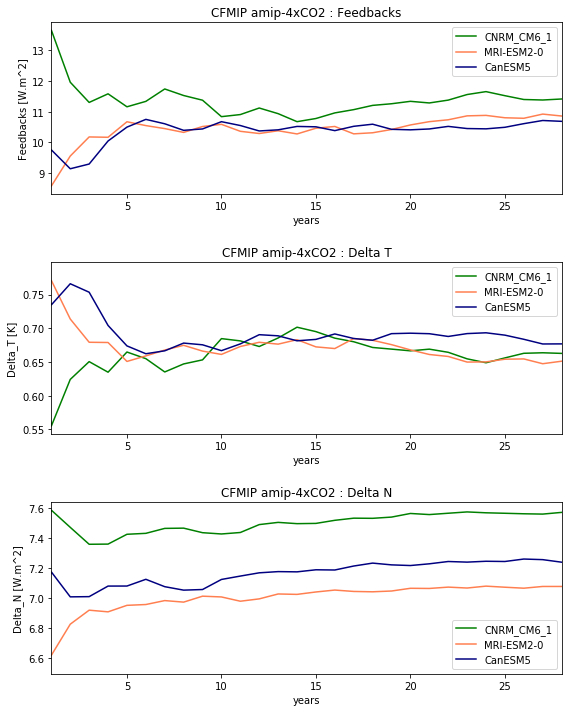

In [73]:
#--------------------------- Plot result : 4xCO2, multi-model--------------------------------------
plt.subplots(figsize=(8,10))

plt.subplot(311)
ax_multimodel=plt.gca()
result.plot(y='Lambda_amip4xCO2',kind='line',title='CFMIP amip-4xCO2 : Feedbacks',legend=True, color='green',ax=ax_multimodel)
result.plot(y='Lambda_mri4xCO2',kind='line',legend=True, color='coral',ax=ax_multimodel)
result.plot(y='Lambda_Can4xCO2',kind='line',legend=True, color='navy',ax=ax_multimodel)
ax_multimodel.set_xlabel('years')
ax_multimodel.set_ylabel('Feedbacks [W.m^2]')
ax_multimodel.legend(['CNRM_CM6_1','MRI-ESM2-0','CanESM5'])
#ax_multimodel.set_ylim([6,10])
ax_multimodel.set_xlim([1,28])

plt.subplot(312)
ax_multimodel1=plt.gca()
result.plot(y='Delta_tas_amip4xCO2',kind='line',title='CFMIP amip-4xCO2 : Delta T',legend=True, color='green',ax=ax_multimodel1)
result.plot(y='Delta_tas_mri4xCO2',kind='line',legend=True, color='coral',ax=ax_multimodel1)
result.plot(y='Delta_tas_Can4xCO2',kind='line',legend=True, color='navy',ax=ax_multimodel1)
ax_multimodel1.set_xlabel('years')
ax_multimodel1.set_ylabel('Delta_T [K]')
ax_multimodel1.legend(['CNRM_CM6_1','MRI-ESM2-0','CanESM5'])
#ax_multimodel1.set_ylim([0,2])
ax_multimodel1.set_xlim([1,28])

plt.subplot(313)
ax_multimodel2=plt.gca()
result.plot(y='Delta_N_amip4xCO2',kind='line',color='green',title='CFMIP amip-4xCO2 : Delta N',legend=True,ax=ax_multimodel2)
result.plot(y='Delta_N_mri4xCO2',kind='line',color='coral',legend=True,ax=ax_multimodel2)
result.plot(y='Delta_N_Can4xCO2',kind='line',color='navy',legend=True,ax=ax_multimodel2)
ax_multimodel2.set_xlabel('years')
ax_multimodel2.set_ylabel('Delta_N [W.m^2]')
ax_multimodel2.legend(['CNRM_CM6_1','MRI-ESM2-0','CanESM5'])
#ax_multimodel2.set_ylim([6.5,8.5])
ax_multimodel2.set_xlim([1,28])

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.40)

# Enregistrement de la figure ......................................

plt.savefig("/data/home/globc/peatier/figures/Lambda_amip-4xCO2_multimodel.pdf", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)